In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:

import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from src.data_processor.phase_3.prob1.v1 import  Phase3Prob1FeatureProcessor
import numpy as np
import gc
from collections import Counter

In [3]:
df = pd.read_parquet("F:/Data/MLOPS_2023/data_phase-3/phase-3/prob-1/raw_train.parquet")

In [4]:
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)
df.shape

(61748, 42)

In [5]:
df2 = pd.read_csv("F:/Data/MLOPS_2023/UNSW_NB15_training-set.csv")
df3 = pd.read_csv("F:/Data/MLOPS_2023/UNSW_NB15_testing-set.csv")
df2 = pd.concat([df2, df3])
del df3
gc.collect()

0

In [6]:
df2.drop(columns=['id','rate','attack_cat'],inplace=True)
df2.drop_duplicates(inplace=True)
df2.shape

(154098, 42)

In [7]:
feat_to_name = {k:v for k,v in zip(df.columns,df2.columns)}
name_to_feat = {k:v for k,v in zip(df2.columns, df.columns)}
df2.columns = [name_to_feat[c] for c in df2.columns]
df2.columns

Index(['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6',
       'feature7', 'feature8', 'feature9', 'feature10', 'feature11',
       'feature12', 'feature13', 'feature14', 'feature15', 'feature16',
       'feature17', 'feature18', 'feature19', 'feature20', 'feature21',
       'feature22', 'feature23', 'feature24', 'feature25', 'feature26',
       'feature27', 'feature28', 'feature29', 'feature30', 'feature31',
       'feature32', 'feature33', 'feature34', 'feature35', 'feature36',
       'feature37', 'feature38', 'feature39', 'feature40', 'feature41',
       'label'],
      dtype='object')

In [8]:
df2 = df2.sample(frac=1, random_state=42, replace=False)

In [9]:
# corr_matrix = df2.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

In [10]:
# to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# to_drop

In [11]:
# # Utility function
# def multi_corr(col1, col2="label", df=df2):
#     '''
#     This function returns correlation between 2 given features.
#     Also gives corr of the given features with "label" afetr applying log1p to it.
#     '''
#     corr = df[[col1, col2]].corr().iloc[0,1]
#     log_corr = df[col1].apply(np.log1p).corr(df[col2])

#     print("Correlation : {}\nlog_Correlation: {}".format(corr, log_corr))

In [12]:
# col_unique_values = df2.nunique()
# col = col_unique_values[col_unique_values>200].index
# for column in col:
#     print("{:-^30}".format(column))
#     multi_corr(column)

In [13]:
# df2['network_bytes'] = df2['sbytes'] + df2['dbytes']
# log1p_col = ['dur', 'sbytes', 'dbytes', 'sload', 'dload', 'spkts', 'stcpb', 'dtcpb', 'smean', 'dmean', 'sjit', 'djit']

In [14]:
# mode_dict = df2.mode().iloc[0].to_dict()
# mode_dict

In [15]:
# for col in df2.columns:
#     val = mode_dict[col]  # Mode value of the column in train data
#     df2[col] = df2[col].fillna(value=val)
#     df2[col] = df2[col].replace(' ', value=val)
#     df2[col] = df2[col].apply(lambda x:"None" if x=="-" else x)

In [16]:
# for col in log1p_col:
    # df2[col] = np.log1p(df2[col])
    

In [17]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [18]:
# for col in df2[categorical_col]:
#     for val in df2[col].unique():
#         df2[col+'_'+ val] = df2[col].eq(val)

In [19]:
# df2.drop(columns=categorical_col,inplace=True)

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier  # LR


In [21]:
HyperParameters={'n_estimators':300,
                 'learning_rate':0.1,
                 'max_depth':32,
                 'colsample_bytree':0.8,
                 'subsample':0.8,
                 'reg_alpha':1,
                 'reg_lambda':0,
                 'random_state':42}

hyper_parameters = HyperParameters.copy()

In [25]:
processor = Phase3Prob1FeatureProcessor()
new_df = processor.fit_transform(df2)
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
FEATURES = processor.data_features['features']
categorical = processor.data_features['categorical_features']
TARGET = 'label'
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
models = []
scores = []
oofs = np.zeros(df2.shape[0])
for i, (train_idx, valid_idx) in enumerate(kfold.split(new_df, df2['label'])):
    X_train = new_df.iloc[train_idx][FEATURES]
    X_valid = new_df.iloc[valid_idx][FEATURES]
    y_train = df2.iloc[train_idx][TARGET]
    y_valid = df2.iloc[valid_idx][TARGET]
    
    # scaler = StandardScaler()
    # scaler = scaler.fit(X_train[num_col])
    # X_train[num_col] = scaler.transform(X_train[num_col])
    # X_valid[num_col] = scaler.transform(X_valid[num_col])
    # model = LogisticRegression(max_iter=7000)
    # model.fit(X_train, y_train)
    # model = LGBMClassifier(**hyper_parameters)
    # model.fit(X_train, y_train,
    #           eval_set=[(X_train, y_train), (X_valid, y_valid)],
    #           categorical_feature=categorical,
    #           eval_metric=["logloss", "auc"],
    #           early_stopping_rounds=50,
    #           verbose=50)
    # model = DecisionTreeClassifier(
    #                    max_depth=15, 
    #                    min_samples_leaf=120, min_samples_split=6)
    # model.fit(X_train, y_train)
    # model = SGDClassifier(loss='log', penalty='l2')
    # model.fit(X_train, y_train)
    model = CatBoostClassifier(iterations=100, learning_rate=0.1, max_depth=16, subsample=0.8, random_state=42,eval_metric='AUC')
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              cat_features=categorical)
    models.append(model)
    y_pred_proba = model.predict_proba(X_valid)[:,1]
    oofs[valid_idx] = y_pred_proba

    print(f"fold {i} : {roc_auc_score(y_valid, y_pred_proba)}")
    scores.append(roc_auc_score(y_valid, y_pred_proba))

print(np.mean(scores), np.std(scores))

0:	test: 0.9687628	test1: 0.9685764	best: 0.9685764 (0)	total: 4.7s	remaining: 7m 45s
1:	test: 0.9720080	test1: 0.9718262	best: 0.9718262 (1)	total: 9.41s	remaining: 7m 41s
2:	test: 0.9731615	test1: 0.9728545	best: 0.9728545 (2)	total: 14.4s	remaining: 7m 44s
3:	test: 0.9749169	test1: 0.9741665	best: 0.9741665 (3)	total: 19.4s	remaining: 7m 44s
4:	test: 0.9765356	test1: 0.9747870	best: 0.9747870 (4)	total: 24.4s	remaining: 7m 44s
5:	test: 0.9773959	test1: 0.9757244	best: 0.9757244 (5)	total: 29.6s	remaining: 7m 43s
6:	test: 0.9777437	test1: 0.9759345	best: 0.9759345 (6)	total: 34.4s	remaining: 7m 37s
7:	test: 0.9782118	test1: 0.9763243	best: 0.9763243 (7)	total: 39.2s	remaining: 7m 31s
8:	test: 0.9786753	test1: 0.9767227	best: 0.9767227 (8)	total: 44.2s	remaining: 7m 27s


In [25]:
oofs = (oofs>0.5).astype(int)

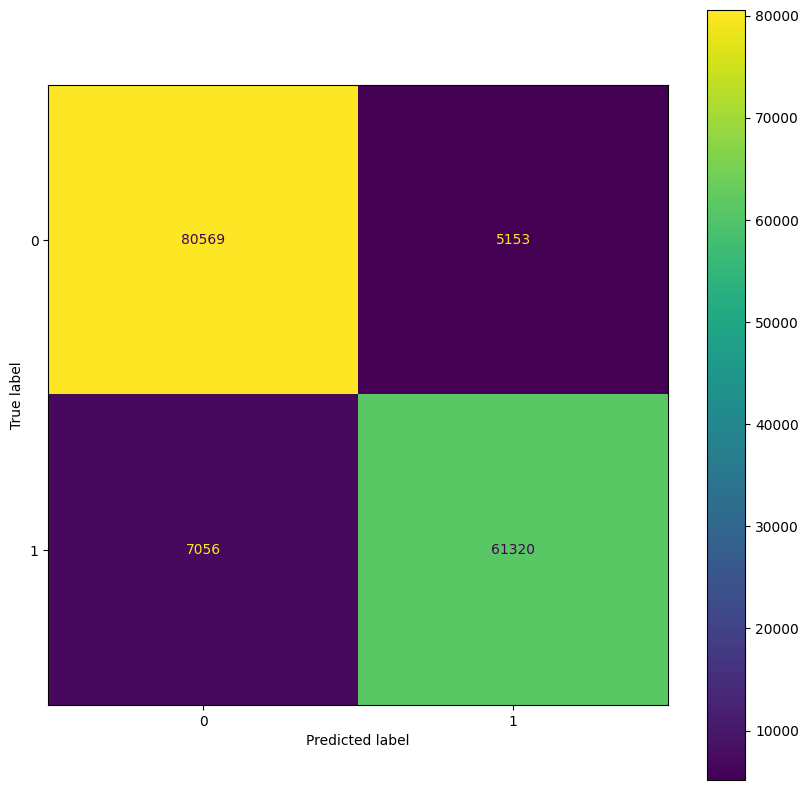

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(df2[TARGET],oofs,labels=models[0].classes_), display_labels=models[0].classes_)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10,10))
disp.plot(ax=ax)

In [30]:
gmodel = LGBMClassifier(**models[0].get_params())
gmodel.fit(new_df[FEATURES], df2[TARGET],
           eval_set=[(new_df[FEATURES],df2[TARGET])],
           eval_metric=["logloss", "auc"],
           categorical_feature=categorical,
           verbose=50)

with open(f'../checkpoints/phase-3/prob-1/v1.pkl','wb') as file:
    pickle.dump(gmodel, file)

[50]	valid_0's binary_logloss: 0.181005	valid_0's auc: 0.97938
[100]	valid_0's binary_logloss: 0.166651	valid_0's auc: 0.982207
[150]	valid_0's binary_logloss: 0.158834	valid_0's auc: 0.984031
[200]	valid_0's binary_logloss: 0.152734	valid_0's auc: 0.985523
[250]	valid_0's binary_logloss: 0.147937	valid_0's auc: 0.986683
[300]	valid_0's binary_logloss: 0.143503	valid_0's auc: 0.987732


In [31]:
feats = pd.DataFrame({'feature':gmodel.feature_name_, 'score':gmodel.feature_importances_}).sort_values('score',ascending=False)

In [32]:
feats.feature[:10].values

array(['feature7', 'feature26', 'feature30', 'feature35', 'feature40',
       'feature21', 'feature25', 'feature20', 'feature24', 'feature12'],
      dtype=object)